# Imports

In [1]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit.library import (
    real_amplitudes,
    z_feature_map,
    zz_feature_map,
    TwoLocal,
    EfficientSU2,
)  # The circuit library is a collection of valuable circuits and building blocks.

from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler as Sampler

# Functions

In [2]:
def calculate_error(
    probability_of_positive_eigenvalue: float, label: float, method: str
):
    """Function calculates error with chosen method. Labels are always labeled like this: class 1 -> -1, class 0 -> +1.
    For MSE labels are +1 (class 0) and -1 (class 1), for CrossEntropy labels are 1 (class 0) and 0 (class 1).
    So in the CrossEntropy part we tell function that label +1 is class 0, and label -1 is class 1"""

    eps = 1e-15
    safe_prob = np.clip(probability_of_positive_eigenvalue, eps, 1 - eps)

    if method == "MSE":
        return (label - (safe_prob - (1 - safe_prob))) ** 2
    elif method == "CrossEntropy":
        if label == 1:
            return -np.log(safe_prob)
        elif label == -1:
            return -np.log(safe_prob)


In [ ]:
def parity_cost_function(
    optimization_parameters_values: list,  # List of theta parameters that are beeing optimized
    quantum_circuit: QuantumCircuit,  # Quantum circuit
    feature_values: np.ndarray,  # Array of all the points in shape (number of points, number of features)
    feature_labels: list,  # Array of labels corresponding to points
    theta_parameters_placeholders_names: ParameterVector,  # Vector of theta parameters placeholders names
    sampler: Sampler,  # Sampler
    method: str | None = "MSE",  # Error calculation method
    cost_value_history: list | None = None,  # List that will contain cost history
    train: bool | None = False,  # Train mode
    test: bool | None = False,  # Test mode
    shots: int | None = 256,  # Number of sampler shots
):
    """
    The purpose of this function is to measure the difference between the expected and measured values. It is intended for use in 0/1 classification, where values are mapped to ±1.
    A qubit measurement can result in 0 (corresponding to +1 on the Bloch sphere) or 1 (corresponding to −1 on the Bloch sphere). Measuring a state such as ∣01⟩ is equivalent to measuring the eigenvalues of the Pauli-Z matrix, which are +1 and −1; their product equals +1⋅(−1)=−1.
    In short, the measurement yields +1 if the number of qubits in state ∣1⟩ (eigenvalue −1) is even, and −1 if it is odd.
    """

    theta_dict = {}

    # Iterating through parameters placeholder names (keys) and assigning parameters values (idx) from list of parameter values in order
    # e.g. theta_dict[theta[0]] =  optimalization_parameters_values[0]
    for idx, key in enumerate(theta_parameters_placeholders_names):
        theta_dict[key] = optimization_parameters_values[idx]

    # Assigning values to placeholders with respect to theta_dict
    quantum_circuit_with_assigned_thetas = quantum_circuit.assign_parameters(theta_dict)

    # Mapping data points labels to coressponding +1 or -1 values
    # if data point label is 0 -> assign +1, if data point label is 1 -> assign -1
    labels_map = list(map(lambda x: 1 if x == 0 else -1, feature_labels))

    # Loop for all data points, data_point is list = [x0, x1, x2, ...]
    pubs = [(quantum_circuit_with_assigned_thetas, feature_values)]

    total_error = 0
    accuracy = 0

    if train:
        job = sampler.run(pubs, shots=shots)
        results = job.result()[0]
        bit_array = results.data.meas

        for idx in range(len(feature_values)):
            count_dict = bit_array[idx].get_counts()

            probability_odd = 0
            probability_even = 0

            # Iterating over keys and values of counts e.g. {"00": int, "01": int, "10": int, "11": int}.
            # If there is even number of 1's in state string represenatation, then multiplying eigenvalues
            # of pauli Z matrix for all qubits will return 1, if there is odd number of 1's -> (-1).
            # This is the probabilty that the multiplication of measured values will return 1 or -1, and these
            # two are correlated with feature labels, so label 0 responds to +1 beeing measured, and label 1 responds
            # to -1 beeing measured

            for state, count in count_dict.items():
                if state.count("1") % 2 == 0:
                    probability_even += count / shots
                elif state.count("1") % 2 != 0:
                    probability_odd += count / shots

            # Calculates the mean squared error for every data point after spcified number of shots
            total_error += calculate_error(
                probability_even, labels_map[idx], method=method
            )

        if cost_value_history is not None:
            cost_value_history.append(total_error / len(feature_values))

        return total_error / len(feature_values)

    if test:
        job = sampler.run(pubs, shots=shots)
        results = job.result()[0]
        bit_array = results.data.meas

        for idx in range(len(feature_values)):
            count_dict = bit_array[idx].get_counts()

            even_count = 0
            odd_count = 0

            for state, count in count_dict.items():
                if state.count("1") % 2 == 0:
                    even_count += count
                elif state.count("1") % 2 != 0:
                    odd_count += count

            if even_count > odd_count and labels_map[idx] == 1:
                accuracy += 1
            elif odd_count > even_count and labels_map[idx] == -1:
                accuracy += 1

        return accuracy / len(feature_values)


In [4]:
def local_cost_function(
    optimization_parameters_values: list,  # List of theta parameters that are beeing optimized
    quantum_circuit: QuantumCircuit,  # Quantum circuit
    feature_values: np.ndarray,  # Array of all the points in shape (number of points, number of features)
    feature_labels: list,  # Array of labels corresponding to points
    theta_parameters_placeholders_names: ParameterVector,  # Vector of theta parameters placeholders names
    sampler: Sampler,  # Sampler
    method: str | None = "MSE",  # List that will contain cost history
    cost_value_history: list | None = None,  # Train mode
    train: bool | None = False,  # Train mode
    test: bool | None = False,  # Test mode
    shots: int | None = 256,  # Number of sampler shots
):
    """
    Measures ONLY Qubit 0 to determine the class.
    State |0> (positive eigenvalue +1) -> Class 0
    State |1> (negative eigenvalue -1) -> Class 1
    """

    theta_dict = {}
    for idx, key in enumerate(theta_parameters_placeholders_names):
        theta_dict[key] = optimization_parameters_values[idx]

    quantum_circuit_with_assigned_thetas = quantum_circuit.assign_parameters(theta_dict)

    # Label Map: 0 -> +1 (State |0>), 1 -> -1 (State |1>)
    labels_map = list(map(lambda x: 1 if x == 0 else -1, feature_labels))

    # Force Array for Batching
    feature_array = np.array(feature_values)
    pubs = [(quantum_circuit_with_assigned_thetas, feature_array)]

    total_error = 0
    accuracy = 0

    if train:
        job = sampler.run(pubs, shots=shots)
        pub_result = job.result()[0]
        bit_array = pub_result.data.meas

        for idx in range(len(feature_array)):
            count_dict = bit_array[idx].get_counts()

            # We count cases when q0 is in state |1> so the eigen value is -1
            count_qubit0_is_1 = 0

            for state, count in count_dict.items():
                # Check ONLY Qubit 0 (the last character in the string) - little endian notation
                if state[-1] == "1":
                    count_qubit0_is_1 += count

            prob_qubit0_is_1 = count_qubit0_is_1 / shots

            # The "Positive Eigenvalue" (+1) corresponds to State |0>
            # So prob(+1) = 1 - prob(|1>)
            prob_pos_eigenvalue = 1.0 - prob_qubit0_is_1

            total_error += calculate_error(
                prob_pos_eigenvalue, labels_map[idx], method=method
            )

        if cost_value_history is not None:
            cost_value_history.append(total_error / len(feature_values))

        return total_error / len(feature_values)

    if test:
        job = sampler.run(pubs, shots=shots)
        pub_result = job.result()[0]
        bit_array = pub_result.data.meas

        for idx in range(len(feature_array)):
            count_dict = bit_array[idx].get_counts()

            count_0 = 0
            count_1 = 0

            for state, count in count_dict.items():
                # Qiskit Little Endian: Qubit 0 is the LAST character
                if state[-1] == "0":
                    count_0 += count
                else:
                    count_1 += count
            # ----------------------------------

            # Logic: Majority Vote on Qubit 0
            # If Qubit 0 is mostly '0' (+1), matches Label +1?
            if count_0 > count_1 and labels_map[idx] == 1:
                accuracy += 1
            # If Qubit 0 is mostly '1' (-1), matches Label -1?
            elif count_1 > count_0 and labels_map[idx] == -1:
                accuracy += 1

        return accuracy / len(feature_values)

In [5]:
class QObjective:
    def __init__(
        self,
        qc,
        X_train,
        y_train,
        ansatz,
        sampler,
        cost_function,
        method="MSE",
        train=False,
        test=False,
        shots=256,
    ):
        self.qc = qc
        self.X_train = X_train
        self.y_train = y_train
        self.ansatz = ansatz
        self.sampler = sampler

        # Store the Strategy
        self.cost_function = cost_function
        self.method = method

        self.train = train
        self.test = test
        self.shots = shots
        self.cost_history = []

    def compute_cost(self, theta_values):
        # We call the stored function dynamically
        return self.cost_function(
            optimization_parameters_values=theta_values,
            quantum_circuit=self.qc,
            feature_values=self.X_train,
            feature_labels=self.y_train,
            theta_parameters_placeholders_names=self.ansatz.parameters,
            sampler=self.sampler,
            method=self.method,
            cost_value_history=self.cost_history,
            train=self.train,
            test=self.test,
            shots=self.shots,
        )

# Data preparation

### Importing dataset

In [6]:
dataset = pd.read_csv("diabetes.csv")

labels = dataset["Outcome"]
features = dataset.drop(columns=["Outcome"])

labels = np.array(labels)
features = np.array(features)

### Scaling feature values to specified range

In [7]:
scaler = MinMaxScaler(feature_range=(0, 2 * math.pi))
X_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, labels, test_size=0.3, random_state=42
)

# Feature map and Ansatz

In [8]:
# Parametervector is a speciall class that can be passed to quantumcircuit as placeholders which are swapped for feature values in the "looper"
num_qubits = len(features[0, :])
num_parameters = 0
sampler = Sampler()
x_params = ParameterVector("x", num_qubits)

# Feature map
feature_map_ry_custom = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    feature_map_ry_custom.ry(x_params[i], i)  # Apply RY(x[i]) to qubit i
    feature_map_ry_custom.rz(x_params[i], i)  # Apply RY(x[i]) to qubit i
    feature_map_ry_custom.rx(x_params[i], i)  # Apply RY(x[i]) to qubit i


feature_map_z = z_feature_map(feature_dimension=num_qubits, reps=1)
feature_map_zz = zz_feature_map(feature_dimension=num_qubits, reps=1)


ansatz_real_amplitudes = real_amplitudes(num_qubits=num_qubits, reps=1)
ansatz_su2 = EfficientSU2(
    num_qubits=num_qubits, reps=1, su2_gates=["ry", "rz"], entanglement="linear"
)
ansatz_two_local = TwoLocal(
    num_qubits=num_qubits,
    rotation_blocks=["rz", "rx"],
    entanglement_blocks="cz",
    reps=1,
    entanglement="circular",  # Tries a ring topology
)

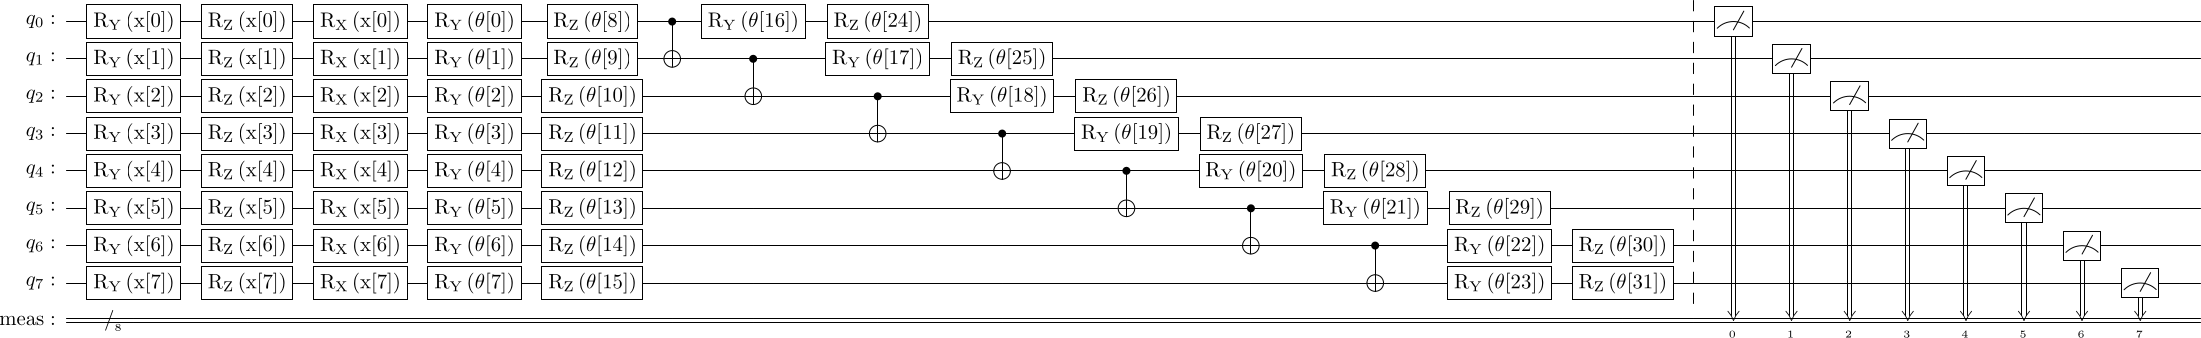

In [9]:
q = feature_map_ry_custom.compose(ansatz_su2.decompose())
q.measure_all()
q.draw(output="latex")

# RUN experiment

In [ ]:
def run_experiment(
    feature_map,
    ansatz,
    cost_func,  # Parity vs Local
    method="MSE",
):
    num_qubits = feature_map.num_qubits

    # Build Circuit
    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    qc.measure_all()

    # Random Init
    theta_values = np.random.random(len(ansatz.parameters)) * 2 * np.pi
    optimizer = COBYLA(maxiter=200)

    # Initialize Objective with the chosen strategy
    model = QObjective(
        qc=qc,
        X_train=X_train,
        y_train=y_train,
        ansatz=ansatz,
        sampler=sampler,
        cost_function=cost_func,  # Pass the function
        method=method,  # Pass the method
        train=True,
        shots=256,
    )

    # Minimize
    print(f"Starting training with {cost_func.__name__} ({method})...")
    result = optimizer.minimize(fun=model.compute_cost, x0=theta_values)

    # Test Accuracy (Using the SAME function/method)
    test_acc = cost_func(
        optimization_parameters_values=result.x,
        quantum_circuit=qc,
        feature_values=X_test,
        feature_labels=y_test,
        theta_parameters_placeholders_names=ansatz.parameters,
        sampler=sampler,
        method=method,
        cost_value_history=[],
        train=False,
        test=True,
        shots=256,
    )

    return test_acc, model.cost_history, result.x

In [ ]:
# 1. Feature Maps
f_maps = {
    # "RY_Custom": feature_map_ry_custom,
    # "ZFeatureMap": feature_map_z,
    "ZZFeatureMap": feature_map_zz,
}

# 2. Ansatzes
ansatzes = {
    # "RealAmplitudes": ansatz_real_amplitudes,
    # "SU2": ansatz_su2,
    "TwoLocal": ansatz_two_local,
}

# 3. Cost Functions (Map Name -> Function Object)
# Ensure these functions are defined in your notebook!
cost_functions = {
    # "Parity": parity_cost_function,
    "Local": local_cost_function,
}

# 4. Error Calculation Methods
loss_methods = ["MSE", "CrossEntropy"]

In [ ]:
output_file = "experiment_results_log.csv"
results_data = []

if not os.path.exists(output_file):
    with open(output_file, "w") as f:
        f.write(
            "Timestamp,Feature_Map,Ansatz,Cost_Function,Method,Accuracy,Final_Cost,Num_Iterations,Optimized_Thetas\n"
        )

# Loop 1: Feature Maps
for f_map_label, f_map in f_maps.items():
    # Loop 2: Ansatzes
    for ansatz_label, anz in ansatzes.items():
        # Loop 3: Cost Strategy (Parity vs Local)
        for cost_label, cost_func in cost_functions.items():
            # Loop 4: Math Method (MSE vs CrossEntropy)
            for method in loss_methods:
                # Define a unique ID for this run
                run_id = f"{f_map_label}_{ansatz_label}_{cost_label}_{method}"
                print(f"--- Running: {run_id} ---")

                # Run the experiment with ALL 4 parameters
                acc, history, optimized_thetas = run_experiment(
                    feature_map=f_map,
                    ansatz=anz,
                    cost_func=cost_func,
                    method=method,
                )

                # Store Results
                results_data.append(
                    {
                        "Feature_Map": f_map_label,
                        "Ansatz": ansatz_label,
                        "Cost_Function": cost_label,
                        "Method": method,
                        "Accuracy": acc,
                        "History": history,
                        "Optimized_Thetas": optimized_thetas,
                    }
                )

                print(f"Result: {acc * 100:.2f}%")

                # Store to File
                thetas_str = ";".join(map(str, optimized_thetas))
                timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                final_cost = history[-1] if history else "N/A"
                iterations = len(history)

                log_line = (
                    f"{timestamp},"
                    f"{f_map_label},"
                    f"{ansatz_label},"
                    f"{cost_label},"
                    f"{method},"
                    f"{acc:.4f},"
                    f"{final_cost},"
                    f"{iterations},"
                    f"{thetas_str}\n"
                )

                with open("experiment_results_log.csv", "a") as f:
                    f.write(log_line)

                # Plotting
                plt.figure(figsize=(10, 8))
                plt.plot(history)
                plt.xlabel("Iteration")
                plt.ylabel("Cost")
                plt.title(f"Run: {run_id}\nAcc: {acc * 100:.1f}%")

                # Save with unique name to prevent overwriting
                plt.savefig(f"Result_{run_id}.png")
                plt.close()

# --- Final Reporting ---
df_results = pd.DataFrame(results_data)

# Reorder columns for readability
cols = ["Feature_Map", "Ansatz", "Cost_Function", "Method", "Accuracy"]
print("\n--- Experiment Summary ---")
print(df_results[cols])